In [ ]:
!pip install transformers
!pip install evaluate
!pip install sentencepiece

In [1]:
import pandas as pd
import torch
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, RandomSampler
from transformers import T5Model, T5ForConditionalGeneration, T5TokenizerFast
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip install rouge-score
from rouge_score import rouge_scorer

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Import custom module

In [3]:
%cd /content/drive/MyDrive/ITMO/src
%ls

/content/drive/MyDrive/ITMO/src
medqadataset.py  __pycache__/  trainer.py


In [4]:
from medqadataset import MedQADataset
import trainer
#from trainer import Trainer

In [ ]:
# For debugging
import importlib
importlib.reload(trainer)

<module 'trainer' from '/content/drive/MyDrive/ITMO/T5QA/src/trainer.py'>

In [15]:
#MODEL_NAME = "cointegrated/rut5-base"    # pre-trained model (first iteration)
#MODEL_NAME = "/content/drive/MyDrive/ITMO/checkpoints/best_model/MedQAModel3"
MODEL_NAME = "/content/drive/MyDrive/ITMO/checkpoints/best_model/MedQAModel4"
TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME, local_files_only=True)
#TOKENIZER = T5TokenizerFast.from_pretrained(MODEL_NAME)
# Set up the T5 model
MODEL = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
# Set up the optimizer
OPTIMIZER = Adam(MODEL.parameters(), lr=0.0001)
Q_LEN = 512    # Question Length
T_LEN = 128    # Target Length
BATCH_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'

In [16]:
DEVICE

'cpu'

### Read Data

In [17]:
PATH = '/content/drive/MyDrive/ITMO'

data = pd.read_csv(PATH + '/data/MedQuAD_clean.csv', index_col=0)
data.index = [i for i in range(len(data))]

data

,question,context,answer,answer_start
0,что такое кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами представляет...,9
1,сколько людей с шерстяными волосами страдают к...,кератодермия с пушистыми волосами представляе...,кератодермия с пушистыми волосами встречается ...,9
2,"каковы генетические изменения, связанные с кер...",кератодермия с пушистыми волосами представляе...,"мутации в генах jup, dsp, dsc2 и kank2 вызываю...",2551
3,передается ли кератодермия с пушистыми волосами?,кератодермия с пушистыми волосами представляе...,большинство случаев кератодермии с курчавыми в...,4573
4,что такое синдром кноблоха?,"синдром кноблоха редкое заболевание, характер...","синдром кноблоха редкое заболевание, характери...",9
...,...,...,...,...
1108,есть ли у вас информация об измерении темпера...,измерение температуры тела может помочь обнару...,измерение температуры тела может помочь обнар...,-1
1109,что такое дефицит аденозинмонофосфатдезаминаз...,дефицит аденозинмонофосфатдезаминазы амф это ...,дефицит аденозинмонофосфат амф дезаминазы это ...,12
1110,сколько людей страдают от дефицита аденозинмо...,дефицит аденозинмонофосфатдезаминазы амф это ...,дефицит амфдезаминазы является одним из наибол...,174
1111,"каковы генетические изменения, связанные с де...",дефицит аденозинмонофосфатдезаминазы амф это ...,мутации в гене ampd1 вызывают дефицит ampдезам...,1495


### Example

In [11]:
sample = data.iloc[0]
encoding = TOKENIZER(
    sample["question"],
    sample["context"],
    max_length=512,
    padding="max_length",
    truncation="only_second",
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors='pt'
)

answer_encoding = TOKENIZER(
    sample["answer"],
    max_length=32,
    padding="max_length",
    truncation=True,
    return_attention_mask=True,
    add_special_tokens=True,
    return_tensors="pt"
)

labels = answer_encoding["input_ids"]

output = MODEL(
    input_ids=encoding["input_ids"],
    attention_mask=encoding["attention_mask"],
    labels=labels
)

In [12]:
labels = TOKENIZER.decode(labels.flatten(), skip_special_tokens=True)

In [13]:
sample["answer"]

'кератодермия с пушистыми волосами представляет собой группу связанных состояний, которые поражают кожу и волосы и во многих случаях повышают риск потенциально опасных для жизни проблем с сердцем. у людей с такими заболеваниями волосы необычно грубые, сухие, тонкие и туго завитые. в некоторых случаях волосы также редкие. шерстистая текстура волос обычно поражает только волосы на коже головы и присутствует с рождения. начиная с раннего возраста, у пораженных людей также развивается ладонноподошвенная кератодермия состояние, при котором кожа на ладонях рук и подошвах ног становится толстой, чешуйчатой \u200b\u200bи мозолистой. кардиомиопатия, заболевание сердечной мышцы, представляет собой опасную для жизни проблему со здоровьем, которая может развиться у людей с кератодермией и пушистыми волосами. в отличие от других особенностей этого состояния, признаки и симптомы кардиомиопатии могут не проявляться до подросткового возраста или позже. осложнения кардиомиопатии могут включать нарушени

In [17]:
labels

'кератодермия с пушистыми волосами представляет собой группу связанных состояний, которые поражают кожу и волос'

In [14]:
output.loss

tensor(1.5536, grad_fn=<NllLossBackward0>)

In [15]:
sample_q = data.iloc[0]["question"]
sample_a = data.iloc[0]["answer"]

sample_encoding = TOKENIZER(sample_q, sample_a)

In [16]:
sample_encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [18]:
preds = [
    TOKENIZER.decode(input_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    for input_id in sample_encoding["input_ids"]
]

In [19]:
" ".join(preds)

'что тако е  кера то дерм ия с пуш исты ми волос ами ?   кера то дерм ия с пуш исты ми волос ами представля ет с обой групп у связ анных состояни й ,  которые пора жают кож у  и волос ы  и во мног их случа ях по выш ают риск потенци ально опас ных  для жизни проблем с серд цем . у люд ей с так ими заболевани ями волос ы не обычн о  груб ые , сух ие , тон кие  и ту го зави тые . в не которы х случа ях волос ы так же ред кие . шер сти стая текст ура волос  обычн о пора жает  только волос ы на кож е голов ы  и присут ствует с  рождени я . начина я с ран него возраст а , у по ражен ных люд ей так же развива ется лад онно по дош вен ная  кера то дерм ия состояни е , при котор ом кожа на  ладо нях рук  и по дош вах  ног станов ится тол стой ,  чеш уй чат ой  и моз оли стой . кардио ми опати я , заболевани е  сердеч ной мыш цы , представля ет с обой опас ную  для жизни проблем у со здоровь ем , котор ая  может раз виться у люд ей с  кера то дерм ией  и пуш исты ми волос ами . в от личие от др

### Dataloaders

In [18]:
train_data, test_data = train_test_split(data, test_size=0.02, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(f"Train shape: {train_data.shape}")
print(f"Validation shape: {val_data.shape}")
print(f"Test shape: {test_data.shape}")

train_sampler = RandomSampler(train_data.index)
val_sampler = RandomSampler(val_data.index)

qa_dataset = MedQADataset(TOKENIZER, data, Q_LEN, T_LEN)

train_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = DataLoader(qa_dataset, batch_size=BATCH_SIZE, sampler=val_sampler)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(OPTIMIZER, patience=5, verbose=True)

Train shape: (872, 4)
Validation shape: (218, 4)
Test shape: (23, 4)


### Train and validation loop

In [19]:
N_EPOCHS = 37
STATE_DICT_PATH = '/content/drive/MyDrive/ITMO/checkpoints/best_model/MedQAModel4'

trainer_module = trainer.Trainer(
    MODEL,
    N_EPOCHS,
    STATE_DICT_PATH,
    train_loader,
    val_loader,
    OPTIMIZER,
    DEVICE,
    TOKENIZER,
    Q_LEN,
    T_LEN,
    scheduler
)

In [25]:
trainer_module.fit()

Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch: 0		Train loss: 0.1214014205808213		Validation loss: 0.009366396986561913


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch: 1		Train loss: 0.11457332212973488		Validation loss: 0.007902634957678277


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch: 2		Train loss: 0.10887308992496735		Validation loss: 0.006774727787441489


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch: 3		Train loss: 0.10355034462013922		Validation loss: 0.005876047231801997


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch: 4		Train loss: 0.09896352518896717		Validation loss: 0.0072079424090175466


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch: 5		Train loss: 0.09241083514270022		Validation loss: 0.005782534084970724


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.81it/s]


Epoch: 6		Train loss: 0.08889204959615792		Validation loss: 0.004678105151635298


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch: 7		Train loss: 0.08598040111807234		Validation loss: 0.0029932227395792405


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 8		Train loss: 0.09562905321598326		Validation loss: 0.01254015933743424


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.77it/s]


Epoch: 9		Train loss: 0.08649398819457979		Validation loss: 0.006393559731077403


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch: 10		Train loss: 0.07465845214015027		Validation loss: 0.005661979599178515


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch: 11		Train loss: 0.07383507154796512		Validation loss: 0.0047653055796135135


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch: 12		Train loss: 0.07072968678890702		Validation loss: 0.0037282879764626905


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch: 13		Train loss: 0.06680618225246532		Validation loss: 0.003838314023265742


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 14		Train loss: 0.0669631302813837		Validation loss: 0.002109370292104855


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 15		Train loss: 0.061146007788820414		Validation loss: 0.002160477655574637


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch: 16		Train loss: 0.061281820532754744		Validation loss: 0.002832902892524461


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch: 17		Train loss: 0.053759366721384774		Validation loss: 0.002129980523088968


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch: 18		Train loss: 0.051679256428759375		Validation loss: 0.0026568113375105896


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 19		Train loss: 0.052785891283371855		Validation loss: 0.0014574374657968293


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 20		Train loss: 0.051283802516724264		Validation loss: 0.001816654977698239


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 21		Train loss: 0.047756792627138285		Validation loss: 0.0012066539770537268


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 22		Train loss: 0.04655631142988835		Validation loss: 0.0023723642450353176


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 23		Train loss: 0.04347933534054308		Validation loss: 0.001504657046800937


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]


Epoch: 24		Train loss: 0.04577233105333983		Validation loss: 0.0011494661617854778


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 25		Train loss: 0.04397678179474154		Validation loss: 0.000750768919698947


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch: 26		Train loss: 0.04278173942520463		Validation loss: 0.0012762644967469069


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 27		Train loss: 0.040376329600144555		Validation loss: 0.0014146036913933297


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.80it/s]


Epoch: 28		Train loss: 0.03801842284316214		Validation loss: 0.0006965783958135448


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 29		Train loss: 0.039124075964161564		Validation loss: 0.0008388026120387208


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 30		Train loss: 0.03473591282344295		Validation loss: 0.001569336096773358


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.81it/s]


Epoch: 31		Train loss: 0.037272214588875786		Validation loss: 0.0010872721089816135


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 32		Train loss: 0.03565104447471815		Validation loss: 0.0021218705602223053


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 33		Train loss: 0.03183175212011562		Validation loss: 0.0006791100531121297


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 34		Train loss: 0.03419455012264918		Validation loss: 0.003119756375037303


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.79it/s]


Epoch: 35		Train loss: 0.03378107345186669		Validation loss: 0.0004376128768936641


Validation batches: 100%|██████████| 55/55 [00:14<00:00,  3.78it/s]

Epoch: 36		Train loss: 0.03519640636919793		Validation loss: 0.0005505113186121558


### Evaluate the results

In [20]:
test_sample = test_data.iloc[3]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"
test_answer = f"{test_sample['answer']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question,
   test_answer,
   print_text=True
)

pred

Контекст: боль в половом члене это любая боль или дискомфорт в половом члене. причины причины могут включать в себя: камни в мочевом пузыре. укусы человека или насекомых. рак полового члена. непроходящая эрекция приапизм. генитальный герпес. инфицированные волосяные фолликулы. инфицированный протез полового члена. инфекция под крайней плотью у необрезанных мужчин баланит. воспаление предстательной железы простатиттравма болезнь пейрони синдром рейтерасерповидноклеточная анемиясифилисуретрит, вызванный хламидиями или гонореей инфекция мочевого пузыря тромб в вене полового члена перелом полового члена уход на дому как лечить боль в половом члене дома зависит от ее причины. поговорите со своим врачом о лечении. пакеты со льдом могут помочь облегчить боль. не прикладывайте лед непосредственно к пенису. вместо этого поместите лед в полотенце или мочалку и приложите завернутый лед, чтобы облегчить боль. если боль в половом члене вызвана заболеванием, передающимся половым путем, важно, чтобы 

{'Reference Answer: ': 'причинами могут быть: камни в мочевом пузыре укусы человека или насекомых рак полового члена непроходящая эрекция приапизм генитальный герпес инфицированные волосяные фолликулы инфицированный протез полового члена инфекция под крайней плотью у необрезанных мужчин баланит воспаление предстательной железы простатит травма болезнь пейрони синдром рейтера серповидноклеточная анемия сифилис уретрит, вызванный хламидиями или гонореей',
 'Predicted Answer: ': 'Ответ: причинами могут быть: камни в мочевом пузыре',
 'BLEU Score: ': {'google_bleu': 0.1262135922330097},
 'RougeL (precision): ': 0}

In [21]:
# Calculate metrics on test
bleu_avg, rouge_avg = trainer_module.calc_avg_metrics(test_data)
print("Test:")
print("BLEU:", bleu_avg)
print("RougeL:", rouge_avg)

Test:
BLEU: 0.14194473035391136
RougeL: 0.06521739130434782


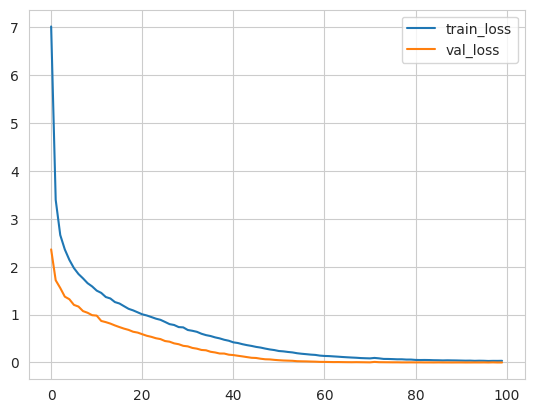

In [33]:
loss_filepath = "/content/drive/MyDrive/ITMO/data/t5_MedQAD_loss_100.csv"
# Plot loss
# General loss with previous steps of fine-tuning
trainer_module.plot_loss(filepath=loss_filepath)
#trainer_module.plot_loss()

### Inference

In [28]:
test_sample = test_data.iloc[3]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что вызывает боль в пенисе? также называется: боль пенис
Контекст: боль в половом члене это любая боль или дискомфорт в половом члене. причины причины могут включать в себя: камни в мочевом пузыре. укусы человека или насекомых. рак полового члена. непроходящая эрекция приапизм. генитальный герпес. инфицированные волосяные фолликулы. инфицированный протез полового члена. инфекция под крайней плотью у необрезанных мужчин баланит. воспаление предстательной железы простатиттравма болезнь пейрони синдром рейтерасерповидноклеточная анемиясифилисуретрит, вызванный хламидиями или гонореей инфекция мочевого пузыря тромб в вене полового члена перелом полового члена уход на дому как лечить боль в половом члене дома зависит от ее причины. поговорите со своим врачом о лечении. пакеты со льдом могут помочь облегчить боль. не прикладывайте лед непосредственно к пенису. вместо этого поместите лед в полотенце или мочалку и приложите завернутый лед, чтобы облегчить боль. если боль в половом чле

In [25]:
test_sample = test_data.iloc[15]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что такое путаница? также называется: дезориентация; мышление неясное; мысли затуманенное
Контекст: замешательство это неспособность думать так ясно и быстро, как обычно. вы можете чувствовать дезориентацию и испытывать трудности с концентрацией внимания, запоминанием и принятием решений. соображения замешательство может нарастать быстро или медленно с течением времени, в зависимости от причины. во многих случаях спутанность сознания длится недолго и проходит. в других случаях это навсегда и неизлечимо. это может быть связано с бредом или деменцией. спутанность сознания чаще встречается у пожилых людей и часто возникает во время пребывания в больнице. некоторые люди с растерянностью могут вести себя странно или необычно или вести себя агрессивно. причины спутанность сознания может быть вызвана различными проблемами со здоровьем, например :алкогольная или наркотическая интоксикация опухоль головного мозга травма головы или травма головы сотрясение мозгалихорадкадисбаланс жидкос

In [26]:
test_sample = test_data.iloc[22]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  каковы симптомы дивертикулеза? также называется: дивертикула дивертикулез; дивертикулит дивертикулез; дивертикулярная болезнь дивертикулез; желудочнокишечное кровотечение дивертикулез; желудочнокишечное кровотечение дивертикулез; желудочнокишечное кровотечение дивертикулез
Контекст: дивертикулез возникает, когда на внутренней стенке кишечника образуются маленькие выпуклые мешочки или мешочки. эти мешочки называются дивертикулами. чаще всего эти мешочки образуются в толстой кишке толстой кишке. они также могут возникать в тощей кишке и тонкой кишке, хотя это встречается реже. причины дивертикулез реже встречается у людей в возрасте 40 лет и моложе. это чаще встречается у пожилых людей. около половины американцев старше 60 лет страдают этим заболеванием. у большинства людей это случается к 80 годам. никто точно не знает, что вызывает образование этих мешочков. в течение многих лет считалось, что диета с низким содержанием клетчатки может сыграть свою роль. недостаток клетчатки м

In [27]:
test_sample = test_data.iloc[9]
test_context = f"Контекст: {test_sample['context']}"
test_question = f"Вопрос: {test_sample['question']}"

pred = trainer_module.predict_answer(
   test_context,
   test_question
)

print(test_question)
print(test_context)
print(pred)

Вопрос:  что вызывает абсцесс?
Контекст: абсцесс это скопление гноя в любой части тела. в большинстве случаев область вокруг абсцесса опухает и воспаляется. причины абсцессы возникают, когда участок ткани заражается, и иммунная система организма пытается бороться с ним и сдерживать его. лейкоциты лейкоциты перемещаются через стенки кровеносных сосудов в область инфекции и собираются в поврежденной ткани. в ходе этого процесса образуется гной. гной это скопление жидкости, живых и мертвых лейкоцитов, мертвых тканей, бактерий или других посторонних веществ. абсцессы могут образовываться практически в любой части тела. кожа, под кожей и зубы являются наиболее распространенными местами. абсцессы могут быть вызваны бактериями, паразитами и инородными веществами. абсцессы на коже легко увидеть. они красные, приподнятые и болезненные. абсцессы в других частях тела могут быть не видны, но они могут вызывать повреждение органов. некоторые типы и локализации абсцессов включают: абдоминальный абсц